In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime

sns.set()

In [2]:
train = pd.read_csv('/Users/andy/Desktop/Case/data/ml_case_training_data.csv')
label = pd.read_csv('/Users/andy/Desktop/Case/data/ml_case_training_output.csv')
hist = pd.read_csv('/Users/andy/Desktop/Case/data/ml_case_training_hist_data.csv')

In [3]:
train = train.merge(label, how='left', on='id')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16096 entries, 0 to 16095
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        16096 non-null  object 
 1   activity_new              6551 non-null   object 
 2   campaign_disc_ele         0 non-null      float64
 3   channel_sales             11878 non-null  object 
 4   cons_12m                  16096 non-null  int64  
 5   cons_gas_12m              16096 non-null  int64  
 6   cons_last_month           16096 non-null  int64  
 7   date_activ                16096 non-null  object 
 8   date_end                  16094 non-null  object 
 9   date_first_activ          3508 non-null   object 
 10  date_modif_prod           15939 non-null  object 
 11  date_renewal              16056 non-null  object 
 12  forecast_base_bill_ele    3508 non-null   float64
 13  forecast_base_bill_year   3508 non-null   float64
 14  foreca

In [4]:
train.drop(['campaign_disc_ele'], inplace=True, axis=1)


numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

new_train = train.select_dtypes(include=numerics)
new_train.drop(['churn'], inplace=True, axis=1)
new_train.head()


consumpations = ['cons_12m', 'cons_gas_12m', 'cons_last_month', 'forecast_base_bill_ele', 'forecast_base_bill_year', 'forecast_bill_12m', 'forecast_cons_12m', 'forecast_cons_year', 'forecast_meter_rent_12m', 'forecast_price_pow_p1', 'imp_cons']

for col in consumpations:
    new_train[col] = new_train[col].clip(lower=0)
    
    
cols = new_train.columns.to_list()
cols.remove('cons_gas_12m')
cols.remove('forecast_discount_energy')
cols.remove('nb_prod_act')


for col in cols:
    Q1 = new_train[col].quantile(0.25)
    Q3 = new_train[col].quantile(0.75)
    IQR = Q3 - Q1
    
    new_train[col] = new_train[col].clip(lower=Q1-1.5*IQR,
                                         upper=Q3+1.5*IQR)
    
new_train.describe([0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T


for col in new_train.columns:
    train[col] = new_train[col]

/System/Volumes/Data/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/System/Volumes/Data/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/System/Volumes/Data/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [5]:
train = train.loc[:, train.isnull().mean() < .5]

train = train.loc[train.date_end.isnull() == 0]
train = train.loc[train.pow_max.isnull() == 0]

from sklearn.impute import KNNImputer

train_ = train.copy()
train_.drop(columns=['id', 'date_activ', 'date_end', 'date_modif_prod', 'date_renewal'], inplace=True) # drop 'id' and cols linked to date since they're irrelevant

# one-hot encoding for categorical variables
train_ = pd.get_dummies(train_, columns=['channel_sales', 'origin_up'], dummy_na=True) 
train_ = pd.get_dummies(train_, columns=['has_gas'])
print(train.shape, '\n')
print(train_.shape, '\n')

# Create an instance of KNNImputer
knn_imputer = KNNImputer(n_neighbors=15)
imputed_train = knn_imputer.fit_transform(train_)
imputed_train = pd.DataFrame(imputed_train, columns=train_.columns)

# still have 5 NaN left, fill with mode in the next step
train[['forecast_discount_energy', 'forecast_price_energy_p1', 'forecast_price_energy_p2', 'forecast_price_pow_p1']] = imputed_train[['forecast_discount_energy', 'forecast_price_energy_p1', 'forecast_price_energy_p2', 'forecast_price_pow_p1']]


lst = ['forecast_discount_energy', 'forecast_price_energy_p1', 'forecast_price_energy_p2', 'forecast_price_pow_p1', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'net_margin']

for col in lst:
    train[col] = train[col].fillna(train[col].median())

(16091, 26) 

(16091, 34) 



In [6]:
hist.dropna(how='any', inplace=True)

grouped_hist = hist.groupby(by='id').mean()

train_total = train.merge(grouped_hist, on='id', how='left')

train_total = train_total[train_total.price_p1_var.isnull() == 0]

In [7]:
# Change data types
import datetime

train_total['date_activ'] = train_total['date_activ'].astype({'date_activ': 'datetime64[ns]'})
train_total['date_end'] = train_total['date_end'].astype({'date_end': 'datetime64[ns]'})
train_total['date_modif_prod'] = train_total['date_modif_prod'].astype({'date_modif_prod': 'datetime64[ns]'})
train_total['date_renewal'] = train_total['date_renewal'].astype({'date_renewal': 'datetime64[ns]'})

train_total['length_of_contract'] = ((train_total['date_end'] - train_total['date_activ']).dt.days)
train_total['length_of_contract'].fillna(train_total['length_of_contract'].median(), inplace=True)


train_total['length_of_satisfaction'] = ((train_total['date_end'] - train_total['date_modif_prod']).dt.days)

train_total['length_of_satisfaction'].fillna(train_total['length_of_satisfaction'].median(), inplace=True)


train_total.drop(['date_activ', 'date_end', 'date_modif_prod', 'date_renewal', 'num_years_antig'], axis=1, inplace=True)
train_total.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,...,pow_max,churn,price_p1_var,price_p2_var,price_p3_var,price_p1_fix,price_p2_fix,price_p3_fix,length_of_contract,length_of_satisfaction
0,48ada52261e7cf58715202705a0451c9,lmkebamcaaclubfxadlmueccxoimlema,116694.375,0,10025.0,5960.34875,4985.625,0.0,304.33,0.095919,...,30.750,0,0.103449,0.092115,0.067241,58.956502,36.356887,8.337051,1460,1460.0
1,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0.000,54946,0.0,0.00000,0.000,0.0,1.78,0.114481,...,30.750,1,0.122856,0.102137,0.072579,40.640023,24.384011,16.256008,1096,1096.0
2,d29c2c54acc38ff3c0614d0a653813dd,NaN,4660.000,0,0.0,189.95000,0.000,0.0,16.27,0.145711,...,13.800,0,0.149934,0.000000,0.000000,44.315416,0.000000,0.000000,2566,2566.0
3,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544.000,0,0.0,47.96000,0.000,0.0,38.72,0.165794,...,13.856,0,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,2192,2192.0
4,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584.000,0,0.0,240.04000,0.000,0.0,19.83,0.146694,...,13.200,0,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,2192,2192.0


In [8]:
train_total['channel_sales'].fillna('channel_sales_Null', inplace=True)
train_total['origin_up'].fillna('origin_up_Null', inplace=True)

train_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16089 entries, 0 to 16090
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        16089 non-null  object 
 1   channel_sales             16089 non-null  object 
 2   cons_12m                  16089 non-null  float64
 3   cons_gas_12m              16089 non-null  int64  
 4   cons_last_month           16089 non-null  float64
 5   forecast_cons_12m         16089 non-null  float64
 6   forecast_cons_year        16089 non-null  float64
 7   forecast_discount_energy  16089 non-null  float64
 8   forecast_meter_rent_12m   16089 non-null  float64
 9   forecast_price_energy_p1  16089 non-null  float64
 10  forecast_price_energy_p2  16089 non-null  float64
 11  forecast_price_pow_p1     16089 non-null  float64
 12  has_gas                   16089 non-null  object 
 13  imp_cons                  16089 non-null  float64
 14  margin

In [9]:
loc = pd.crosstab(round(train_total['length_of_contract']/365), train_total['churn'])

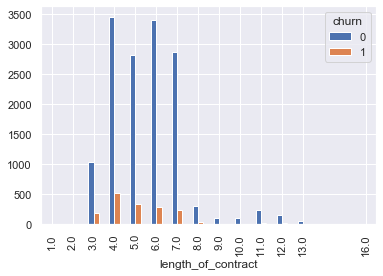

In [10]:
loc.plot(kind='bar')
plt.show()

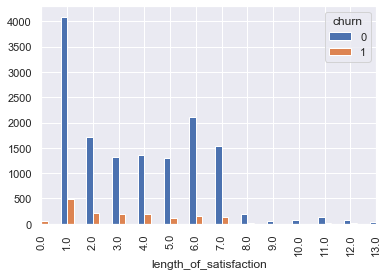

In [11]:
los = pd.crosstab(round(train_total['length_of_satisfaction']/365), train_total['churn'])
los.plot(kind='bar')
plt.xlim(0, 13)
plt.show()

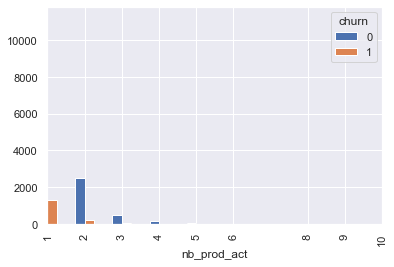

In [12]:
noc = pd.crosstab(train_total['nb_prod_act'], train_total['churn'])
noc.plot(kind='bar')
plt.xlim(1, 10)
plt.show()

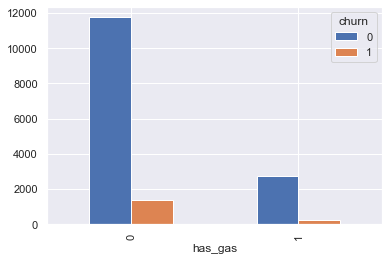

In [13]:
train_total['has_gas'].replace({'f': 0, 't': 1}, inplace=True)

gas = pd.crosstab(train_total['has_gas'], train_total['churn'])
gas.plot(kind='bar')
plt.show()

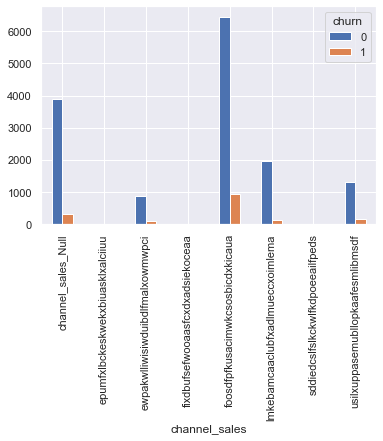

In [14]:
channel = pd.crosstab(train_total['channel_sales'], train_total['churn'])
channel.plot(kind='bar')
plt.show()

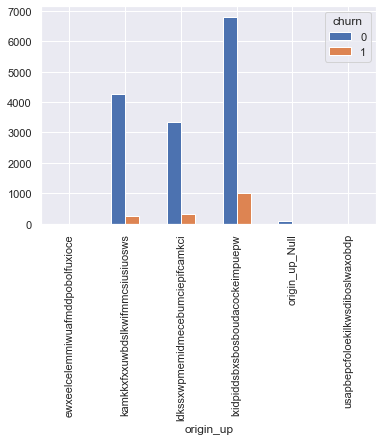

In [15]:
origin = pd.crosstab(train_total['origin_up'], train_total['churn'])
origin.plot(kind='bar')
plt.show()

In [16]:
train_total.forecast_discount_energy.value_counts()

0.000000     15476
30.000000      280
24.000000      112
28.000000      102
22.000000       57
2.000000        17
25.000000        7
26.000000        5
19.000000        4
1.600000         4
17.000000        3
1.866667         3
50.000000        2
5.466667         2
3.866667         2
23.000000        2
10.000000        2
4.000000         2
9.333333         1
5.000000         1
5.600000         1
12.000000        1
3.066667         1
3.333333         1
7.333333         1
Name: forecast_discount_energy, dtype: int64

In [17]:
def discount_level(ds):
    if ds == 0:
        return 0
    elif ds <= 10:
        return 10
    elif ds > 10 and ds <= 20:
        return 20
    else:
        return 30
    
    
train_total['discount_level'] = train_total['forecast_discount_energy'].apply(discount_level)

train_total.discount_level.value_counts()

0     15476
30      567
10       38
20        8
Name: discount_level, dtype: int64

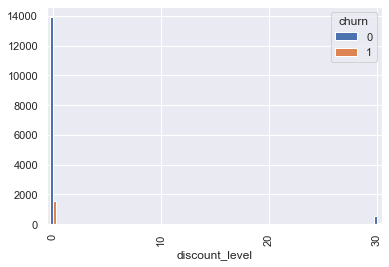

In [18]:
discount = pd.crosstab(train_total['discount_level'], train_total['churn'])
discount.plot(kind='bar')
plt.show()